In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils.file_dialog_utils import pick_media_cv2

def show(img, title="", size=8):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(size, size))
    plt.title(title)
    plt.axis("off")
    plt.imshow(img_rgb)
    plt.show()

def show_gray(img, title="", size=8):
    plt.figure(figsize=(size, size))
    plt.title(title)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.show()

In [8]:
# Image or Video (target source)
media_obj, media_path, source_kind = pick_media_cv2(title="Select a wheel frame image or video")
if source_kind == "image":
    frame = media_obj
elif source_kind == "video":
    cap = media_obj
    ret, frame = cap.read()
    cap.release()
else:
    raise ValueError("Unsupported media type selected.")

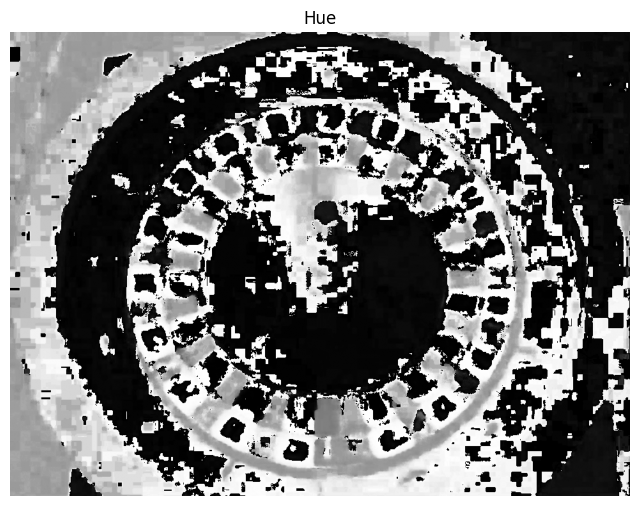

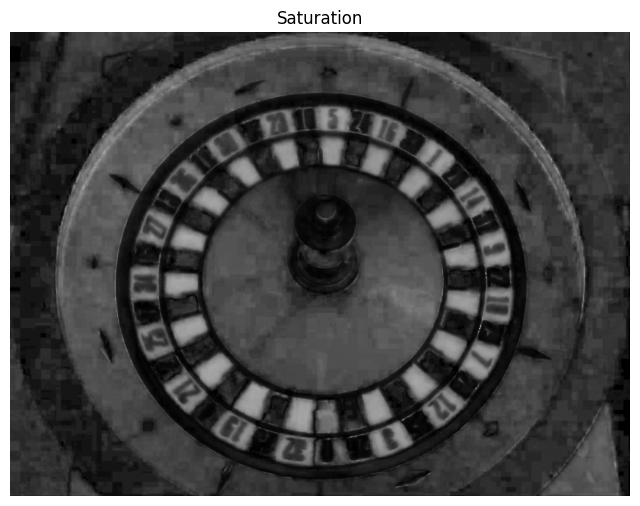

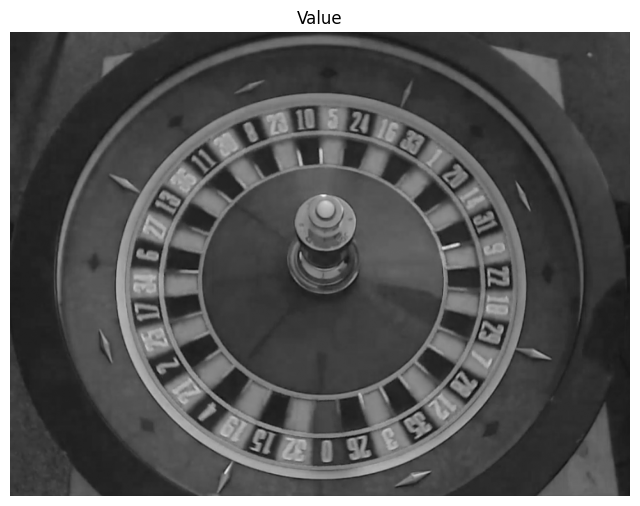

In [9]:
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

h, s, v = cv2.split(hsv)

show_gray(h, "Hue")
show_gray(s, "Saturation")
show_gray(v, "Value")

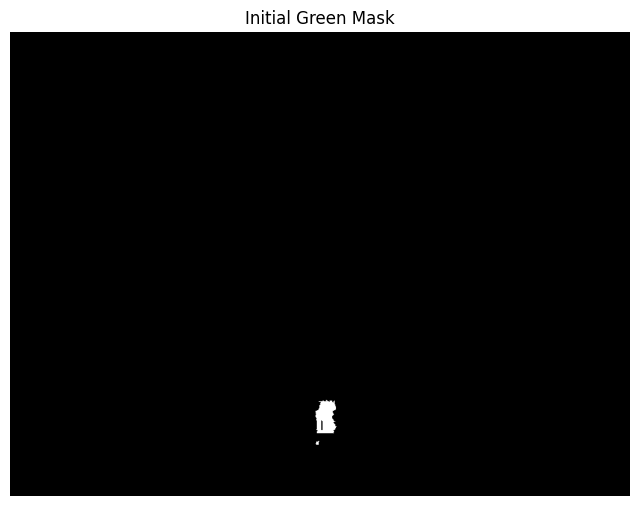

In [10]:
# Rough initial guess — you will tune these
lower_green = np.array([40, 50, 50])
upper_green = np.array([90, 255, 255])

mask = cv2.inRange(hsv, lower_green, upper_green)
show_gray(mask, "Initial Green Mask")

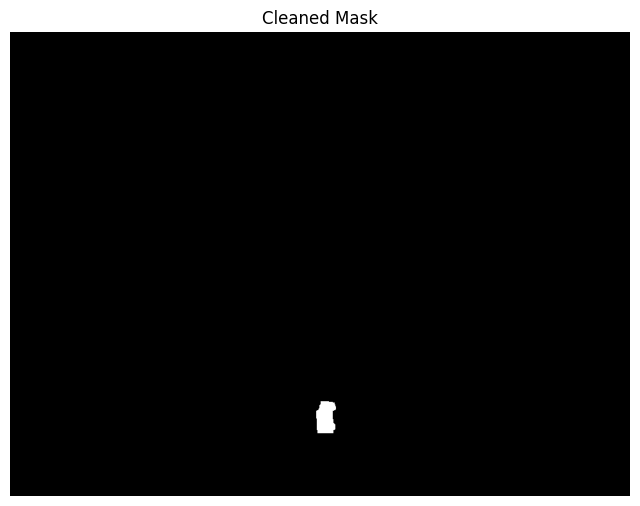

In [11]:
kernel = np.ones((5, 5), np.uint8)

mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

show_gray(mask_clean, "Cleaned Mask")

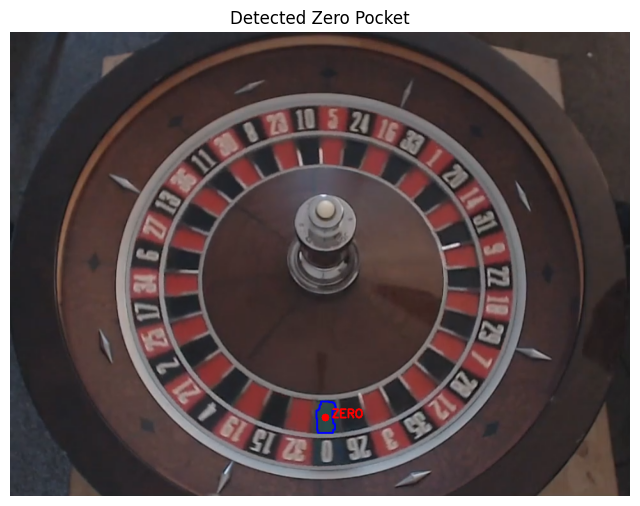

In [12]:
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = frame.copy()
cx = cy = None

if contours:
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 80:  # ignore noise; tune as needed
            continue
        
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        
        cv2.drawContours(output, [cnt], -1, (255, 0, 0), 2)
        cv2.circle(output, (cx, cy), 6, (0, 0, 255), -1)
        cv2.putText(output, "ZERO", (cx+10, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        break

show(output, "Detected Zero Pocket")